In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import glob
import random
import os
import numpy as np
import time
import sys
import datetime
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [2]:
#parameters

img_h = 256 
img_w = 256

batch_size=32
n_epochs=100
lr=0.0002
lambda_pixel = 100

sample_interval = 200
checkpoint_interval = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#receptive field of the discriminator PatchGAN
patch = (1, img_h // 2 ** 4, img_w // 2 ** 4)

## Creating Dataloaders for edges2shoes dataset

In [3]:
# !unzip ./edges2shoes.zip -d ./edges2shoes

In [4]:
os.makedirs('./edges2shoes/saved_images',exist_ok=True)
os.makedirs('./edges2shoes/saved_models',exist_ok=True)

In [5]:
#We are Randomly sampling 15% data to use for training

train_dir=r'edges2shoes/train'
total_files=len(os.listdir(train_dir))
no_files_to_delete=int(0.85 * total_files)

all_files=[Path(train_dir,fname).as_posix() for fname in os.listdir(train_dir)]
sampled_files=random.sample(all_files, no_files_to_delete)


for file in sampled_files:
    os.remove(file)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted([img_path.as_posix() for img_path in Path(root).glob('*')])
        #self.files_target = sorted([img_path.as_posix() for img_path in Path(root_target).glob('*')])

        #assert len(self.files_source) == len(self.files_target)

    def __getitem__(self, index):

        img = Image.open(self.files[index])
      
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.25:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [7]:
transforms_ = [
    
    transforms.Resize((img_h,img_w), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset("./edges2shoes/train", transforms_=transforms_),
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_dataloader = DataLoader(
    ImageDataset("./edges2shoes/val", transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Defining the Generator: UNet

In [8]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

## Defining the Discriminator: PatchGAN

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Initialize Model

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
generator = GeneratorUNet()
discriminator = Discriminator()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

#Loss Functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

#Converting them to CUDA
criterion_GAN.to(device)
criterion_pixelwise.to(device)
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

## Training Loop

In [12]:
def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = imgs['A'].to(device)
    real_B = imgs['B'].to(device)
    fake_B = generator(real_A)

    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, './edges2shoes/saved_images/{0}.png'.format(str(batches_done)), nrow=4, normalize=True)

In [13]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

# scheduler_G = torch.optim.lr_scheduler.MultiStepLR(optimizer_G, milestones=[100,150],gamma=0.5)
# scheduler_D = torch.optim.lr_scheduler.MultiStepLR(optimizer_D, milestones=[100,150],gamma=0.5)

scheduler_G =torch.optim.lr_scheduler.OneCycleLR(optimizer_G, 0.002, epochs=n_epochs,steps_per_epoch=len(dataloader))
scheduler_D = torch.optim.lr_scheduler.OneCycleLR(optimizer_D, 0.002, epochs=n_epochs,steps_per_epoch=len(dataloader))

prev_time = time.time()

for epoch in range(0, n_epochs):
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        valid = torch.ones(real_A.size(0),*patch,device=device)
        fake  = torch.zeros(real_A.size(0),*patch,device=device)

        #GENERATOR
        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)

        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        #DISCRIMINATOR
        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )

        if batches_done % sample_interval == 0:
                sample_images(batches_done)

        

    scheduler_G.step()
    scheduler_D.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "./edges2shoes/saved_models/%s_generator_%d.pth" % ('edges2shoes', epoch))
        torch.save(discriminator.state_dict(), "./edges2shoes/saved_models/%s_discriminator_%d.pth" % ('edges2shoes', epoch))
    

[Epoch 99/100] [Batch 155/156] [D loss: 0.091588] [G loss: 10.239679, pixel: 0.096938, adv: 0.545898] ETA: 0:00:00.497204

## Saving Images as a Video

In [ ]:
import cv2
from pathlib import Path

In [ ]:
import cv2
import os

image_folder = r'D:\pytorch-zero to gans\pix2pix\temp\facades\saved_images'
video_name = r'D:\pytorch-zero to gans\pix2pix\temp\facades\gans_training.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 2, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

## Displaying Images generated from Validation dataset during traing time 

https://youtube.com/shorts/LdAA3Eg-wvM

## Displaying some Images from Gans Training 

In [16]:
from IPython.display import Image

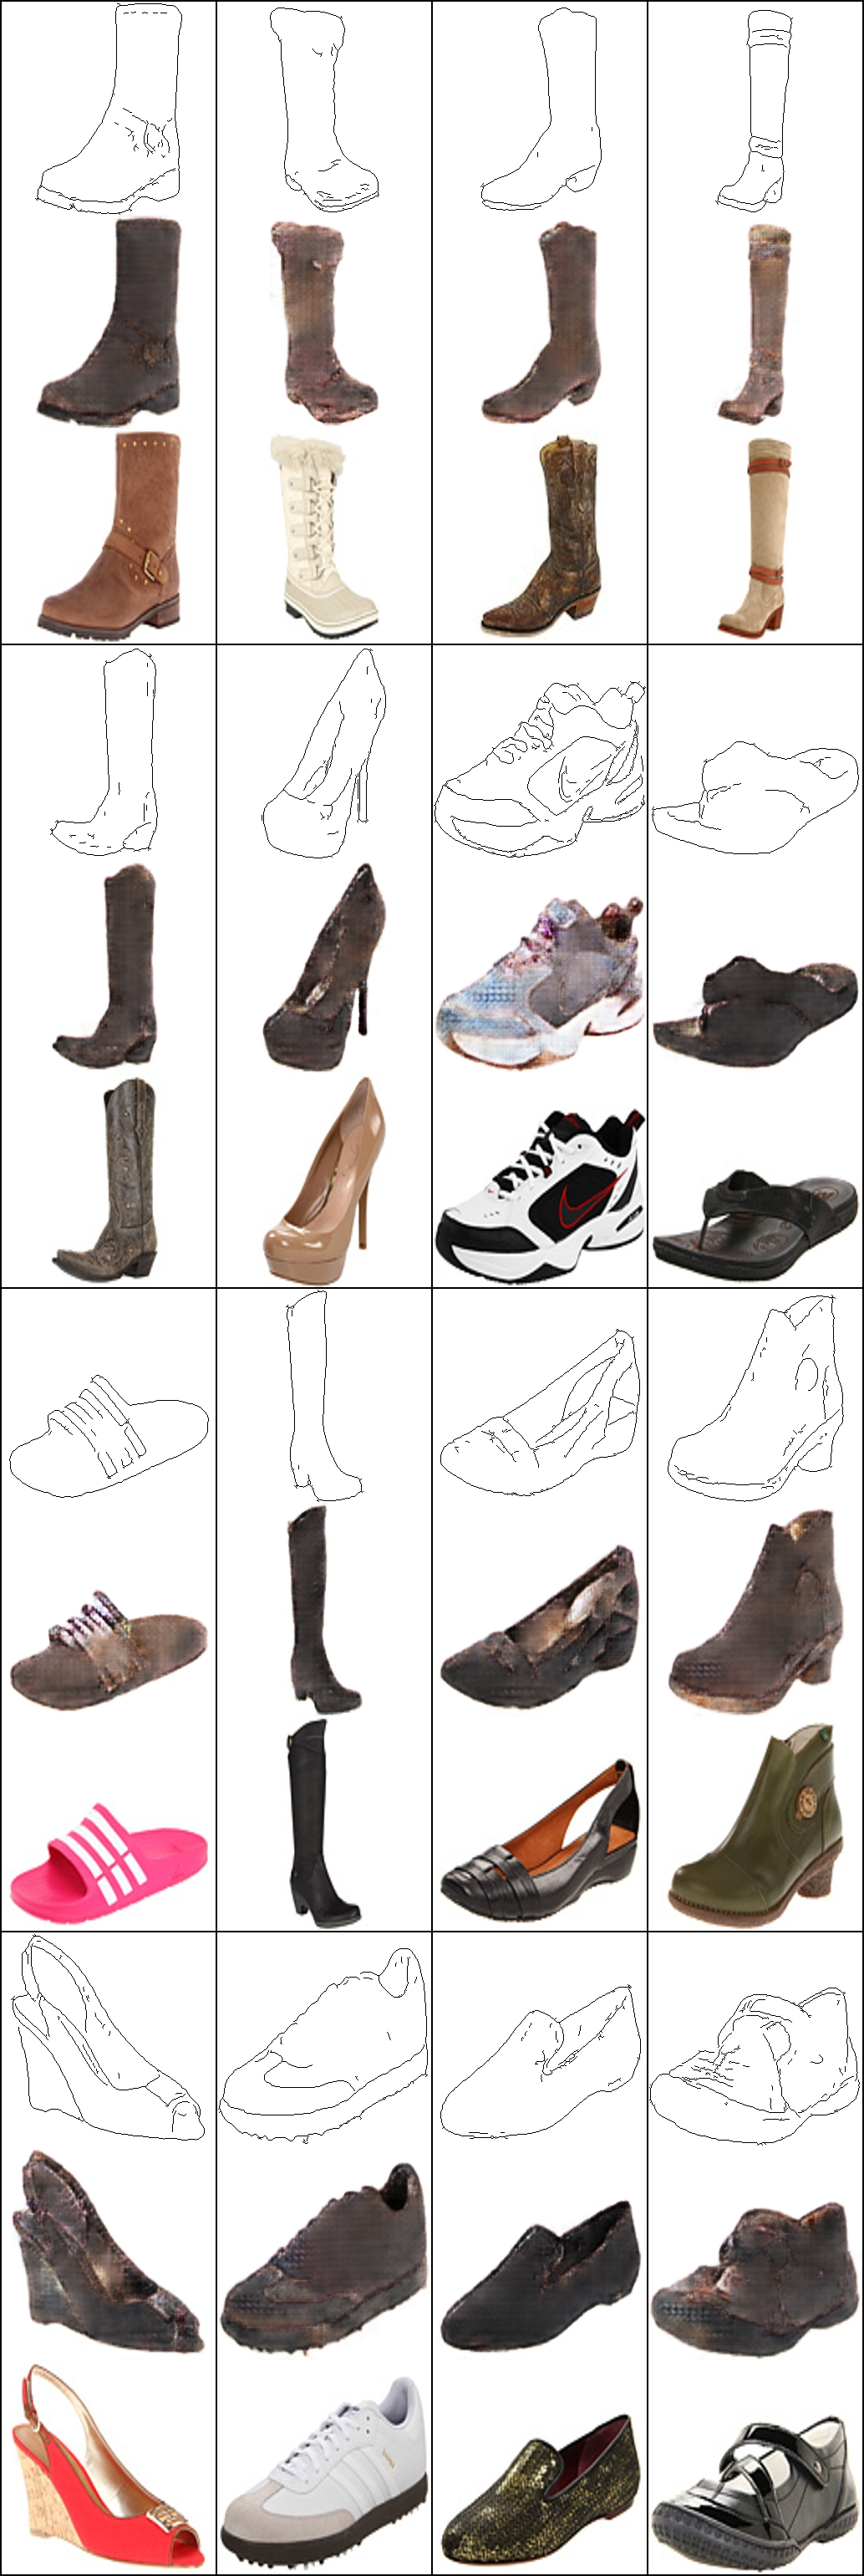

In [17]:
Image(r'edges2shoes/to_be_downlaoded/saved_images/15400.png')

## Inference

In [ ]:
from PIL import Image

In [ ]:
generator = GeneratorUNet()
generator.to(device)
generator.load_state_dict(torch.load(r'edges2shoes/to_be_downlaoded/saved_models/edges2shoes_generator_80.pth'))

<All keys matched successfully>

In [24]:
image_path=r'edges2shoes/val/171_AB.jpg'
transforms_ = [
    
    transforms.Resize((img_h,img_w), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
transform = transforms.Compose(transforms_)

image = Image.open(image_path)
w, h = image.size

img_input = image.crop((0, 0, w / 2, h))
img_output = image.crop((w / 2, 0, w, h))


img_tensor = transform(img_input)
img_tensor=img_tensor.unsqueeze(0).to(device)
img_tensor.shape

torch.Size([1, 3, 256, 256])

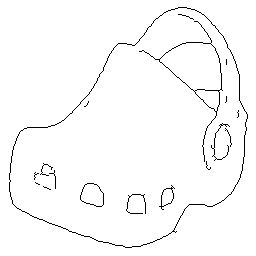

In [28]:
#Input Image
img_input

In [29]:
generated_img=generator(img_tensor)

In [30]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return images * stds + means

stats = ([0.5,0.5,0.5], [0.5,0.5,0.5])
out=denormalize(generated_img, *stats)
out=out.squeeze(0)

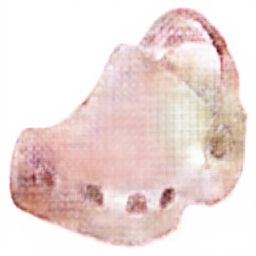

In [31]:
#Generated Image
transforms.ToPILImage()(out)

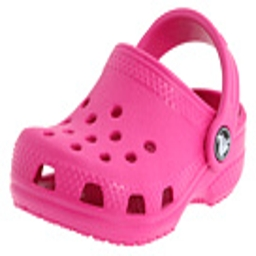

In [32]:
#Real Ground Truth
img_output
